### Установка BigARTM
Все точно как в инструкции на их сайте, только без установки питона и пипа.

In [ ]:
!apt-get --yes install git make cmake build-essential libboost-all-dev

In [ ]:
!pip install protobuf tqdm wheel

In [ ]:
!git clone --branch=stable https://github.com/bigartm/bigartm.git

In [ ]:
cd bigartm

In [ ]:
mkdir build

In [ ]:
cd build

/content/bigartm/build


In [ ]:
!cmake ..

In [ ]:
!make

In [ ]:
!pip install python/bigartm*.whl -U

In [ ]:
cd ../.. 

/content


In [ ]:
!pip install pymorphy2[fast] nltk gensim

In [ ]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
from pymorphy2 import MorphAnalyzer
import gensim, nltk
import string
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

Нормализация

In [ ]:
nltk.download('punkt');nltk.download('stopwords')

In [ ]:
stops = set(stopwords.words('russian')) | {'gt',}
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)


def opt_normalize(texts, top=None):
    uniq = Counter()
    for text in texts:
        uniq.update(text)
    
    norm_uniq = {word:morph.parse(word.replace(':', ''))[0].normal_form for word, _ in uniq.most_common(top)}
    
    norm_texts = []
    for text in texts:
        
        norm_words = [norm_uniq.get(word) for word in text]
        norm_words = [word for word in norm_words if word and word not in stops]
        norm_texts.append(norm_words)
        
    return norm_texts

def tokenize(text):
    words = [word.strip(string.punctuation) for word in text.split()]
    words = [word for word in words if word]
    
    return words

In [ ]:
!wget https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/habr_texts.txt.zip

In [ ]:
!unzip habr_texts.txt.zip

In [ ]:
texts = open('habr_texts.txt').read().splitlines()
texts = opt_normalize([tokenize(remove_tags(text.lower())) for text in texts], 30000)

Нграммы

In [ ]:
ph = gensim.models.Phrases(texts, scoring='npmi', threshold=0.1, 
                           common_terms=set(stopwords.words('russian'))) 
p = gensim.models.phrases.Phraser(ph)
ngrammed_habr_texts = p[texts]

.vw формат

In [ ]:
f = open('ngrammed_habr_texts.vw', 'w')

for i, text in enumerate(texts):
    c = Counter(text)
    doc = 'doc_'+ str(i) + ' '
    vw_text = ' '.join([x+':'+str(c[x]) for x in c])
    
    f.write(doc + vw_text  + '\n')
f.close()

In [ ]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value))
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value))
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path='ngrammed_habr_texts.vw', data_format='vowpal_wabbit', target_folder='batches', batch_size=1000)

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', data_format='batches')

In [ ]:
dictionary = artm.Dictionary()

## Обучение модели


Модель 1

min_df=20, max_df=200

количество тем=200

phi_tau\*0.5 и theta_tau\*0.1 в течение 10 итераций. 

In [ ]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class', min_df=20, max_df=2000)

In [ ]:
dictionary.save_text('dict.txt')
# dictionary = artm.Dictionary()
# dictionary.load_text('dict.txt')

In [ ]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

In [ ]:
model_artm.initialize(dictionary=dictionary)

In [ ]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1))
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10))

In [ ]:
model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

In [ ]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                              topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                               topic_names=['topic_{}'.format(i) for i in range(1, 200)]))

In [ ]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [ ]:
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

Sparsity Phi: 0.658 ARTM)
Sparsity Theta: 0.106 (ARTM)
Kernel contrast: 0.223 (ARTM)
Kernel purity: 0.201 (ARTM)
Perplexity: 374.264 (ARTM)


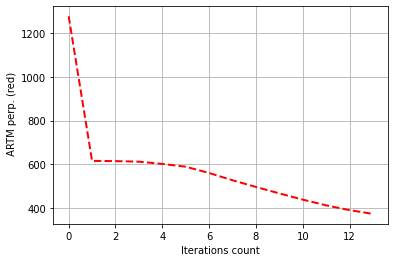

In [ ]:
print_measures(model_artm)

In [ ]:
for topic_name in model_artm.topic_names[:50]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError:
        continue

Модель 2

min_df=15, max_df=1500

количество тем=50

phi_tau\*0.5 и theta_tau\*0.1 в течение 10 итераций. 

In [ ]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=15, max_df=1500)

artm.Dictionary(name=3d189645-c58d-4bac-9a23-37145d78190d, num_entries=8957)

In [ ]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(50)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

In [ ]:
model_artm.initialize(dictionary=dictionary)

In [ ]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1))
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10))

In [ ]:
model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

In [ ]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]))

In [ ]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [ ]:
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

Sparsity Phi: 0.492 ARTM)
Sparsity Theta: 0.032 (ARTM)
Kernel contrast: 0.244 (ARTM)
Kernel purity: 0.357 (ARTM)
Perplexity: 298.712 (ARTM)


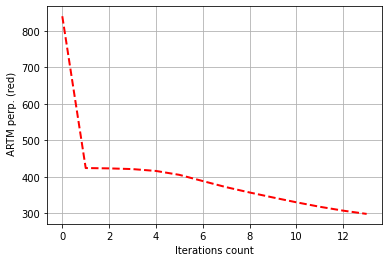

In [ ]:
print_measures(model_artm)

In [ ]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: 
        continue

Модель 3 (самая хорошая)

min_df=15, max_df=1500

количество тем=100

phi_tau\*0.4 и theta_tau\*0.2 в течение 15 итераций

In [ ]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=15, max_df=1500)

artm.Dictionary(name=4e75077c-e25b-433a-92bb-0ecda81a1ac9, num_entries=8957)

In [ ]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(100)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

In [ ]:
model_artm.initialize(dictionary=dictionary)

In [ ]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1))
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10))

In [ ]:
model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

In [ ]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]))

In [ ]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [ ]:
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(15):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.4))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.2))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

Sparsity Phi: 0.734 ARTM)
Sparsity Theta: 0.098 (ARTM)
Kernel contrast: 0.273 (ARTM)
Kernel purity: 0.432 (ARTM)
Perplexity: 246.053 (ARTM)


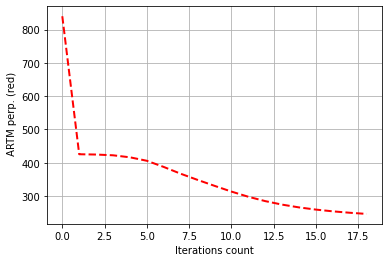

In [ ]:
print_measures(model_artm)

In [ ]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: 
        continue

3 хороших темы

In [ ]:
best_3 = [model_artm.topic_names[11], model_artm.topic_names[25], model_artm.topic_names[26]]
for best_name in best_3:
    print(best_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[best_name]:
            print(x)
        print('---------')
    
    except KeyError: 
        continue

topic_11: 
сеть
интернет
сервис
протокол
связь
доступ
передача
интерфейс
обмен
vpn
---------
topic_25: 
доклад
конференция
тема
участник
рассказать
презентация
мероприятие
рассказывать
участие
слайд
---------
topic_26: 
мозг
клетка
тело
движение
учёный
рука
животное
ген
организм
глаз
---------
